# Rats in the City

Rats have long been drawn to America's largest city and the wealth of opportunities it offers. Throughout the course of this series I will take a look into which parts of NYC rats love the most. 

The first part of the series will be munging the data to make sure that we have all the information that we want to be incoporated in the dataset. 

---

##### Libraries

We'll be using the [`requests`](http://docs.python-requests.org/en/master/) library to extract the data from the url and `pandas` to handle much of the munging and wrangling of the dataset. Additionally, we'll be using [`geopandas`](http://geopandas.org) to handle the coordinate data.

If you don't have any of these libraries, a simple `pip install ...` should do the trick.

In [1]:
import os
import requests
import glob

import pandas as pd
import geopandas as gpd
import numpy as np
from math import pi

---
#### Get Data
NYC Open Data link - NYC provides a variety of great datasets to take a look at. I'd definitely recommend taking a look at their open data portal for data or looking at other cities opend data portals. 

In [2]:
data_url = "https://nycopendata.socrata.com/api/views/3q43-55fe/rows.csv?accessType=DOWNLOAD"
def download_data(url, path="data", name="Rat_Sightings.csv"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)
        
download_data(url=data_url, name="Rat_Sightings.csv")
os.listdir("./data/")

['f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson',
 '.DS_Store',
 'Rat_Sightings.pkl',
 'Rat_Sightings.csv',
 'd085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson',
 'neighborhoods.htm',
 '.ipynb_checkpoints',
 '42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson',
 'data']

---

#### Ratty data...

Time to read in the data and take a first look. 

In [3]:
# read in rat sightings data
df = pd.read_csv("./data/Rat_Sightings.csv")
print(df.shape)
print(df.info())
df.head()

/Users/dominic/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(117496, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117496 entries, 0 to 117495
Data columns (total 38 columns):
Unique Key                        117496 non-null int64
Created Date                      117496 non-null object
Closed Date                       104668 non-null object
Agency                            117496 non-null object
Agency Name                       117496 non-null object
Complaint Type                    117496 non-null object
Descriptor                        117496 non-null object
Location Type                     117490 non-null object
Incident Zip                      117103 non-null float64
Incident Address                  107389 non-null object
Street Name                       107388 non-null object
Cross Street 1                    96036 non-null object
Cross Street 2                    95999 non-null object
Intersection Street 1             9920 non-null object
Intersection Street 2             9920 non-null object
Address Type               

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,15633054,01/01/2010 11:20:45 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11365.0,59-13 159 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.739983,-73.809299,"(40.73998332248969, -73.80929891501533)"
1,15633304,01/02/2010 12:50:36 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10016.0,2 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.743161,-73.976983,"(40.74316088098852, -73.97698314758436)"
2,15633594,01/01/2010 03:05:37 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11377.0,31-14 58 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756987,-73.903618,"(40.756986581184535, -73.90361811283164)"
3,15633599,01/01/2010 08:52:19 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.688903,-73.980929,"(40.68890317557533, -73.98092864957985)"
4,15633605,01/01/2010 04:14:27 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10467.0,2504 BRONX PARK EAST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.863614,-73.870441,"(40.8636140600279, -73.87044117516707)"


---

### Data Wrangling

---

#### Removing Nulls from Zip Code Column

We will be using zip codes for a lot of our later joins and it will be our most granular level of viewing the data. Therefore, we're going to exclude any rows that are missing a zip code. 

In [4]:
# looks for only finite values of zip code
df = df[np.isfinite(df["Incident Zip"])]

# also, let's work with the columns needed for our analysis.
df = df[["Created Date", "Location Type", "Incident Zip", "Location"]]
df.head()

,Created Date,Location Type,Incident Zip,Location
0,01/01/2010 11:20:45 AM,1-2 Family Dwelling,11365.0,"(40.73998332248969, -73.80929891501533)"
1,01/02/2010 12:50:36 AM,Commercial Building,10016.0,"(40.74316088098852, -73.97698314758436)"
2,01/01/2010 03:05:37 PM,3+ Family Apt. Building,11377.0,"(40.756986581184535, -73.90361811283164)"
3,01/01/2010 08:52:19 PM,Other (Explain Below),11201.0,"(40.68890317557533, -73.98092864957985)"
4,01/01/2010 04:14:27 PM,3+ Family Apt. Building,10467.0,"(40.8636140600279, -73.87044117516707)"


---

#### Zip Code /= Floats

We don't necessarily want our zip codes represented as float values. 

In [5]:
df["Incident Zip"] = df["Incident Zip"].astype('str', copy=False)
# whenever I convert the column directly into integers, there
# appears to be a lost of values where their original values
# are modified or deleted. So by converting it string it should
# keep the values as is. Then I am going to run a str.split() fun
# to remove the decimals and reassign it back to the column

def remove_dec(row):
    
    return str(row).split(".")[0]

#remove decimals
df["Incident Zip"] = df["Incident Zip"].map(remove_dec)
df["Incident Zip"].head()

0    11365
1    10016
2    11377
3    11201
4    10467
Name: Incident Zip, dtype: object

---

#### In Fact, Zip Code aren't really numbers...?

Zip codes really take on a more categorical role in our society than a numerical role. `My zip code + your zip code = Maybe a zip code in a very different place.`

In [6]:
#rename the col
df.rename(columns = {"Incident Zip":"postalCode"}, inplace=True)
# all the  columns in this dataset are string
for col in df.columns:
    if col != "postalCode":
        df[col] = df[col].astype("str", copy=False)
    else:
        df["postalCode"] = df["postalCode"].astype("int64", copy=False)
        
df = df.sort_values("postalCode")
df.head()

,Created Date,Location Type,postalCode,Location
113064,07/30/2017 12:00:00 AM,Other (Explain Below),83,"(40.782272106294286, -73.97097190908056)"
51699,09/15/2014 12:00:00 AM,Other (Explain Below),83,"(40.7794758468835, -73.97357287287964)"
96227,08/27/2016 12:00:00 AM,Other (Explain Below),83,"(40.775553876942546, -73.97472619286276)"
75761,09/15/2014 12:00:00 AM,Other (Explain Below),83,"(40.7794758468835, -73.97357287287964)"
67269,11/16/2017 12:00:00 AM,Other (Explain Below),83,"(40.78286341773367, -73.96535663892631)"


---

####  *The Ghost Zip Code*

Upon working with this dataset, I kept coming across this legitmate but not legitimate zipcode. The dataset above shows the zipcode as `83`, but it is actually `00083` and is real ... but not real. 

So apparently, this zip code references to Central Park, NYC. However, some agencies/departments of NYC totally disregard it and others acknowledge it making it a *'real' zip code* that some people do not acknowledge.

Because, some of our later data is actually going to come from departments that do not incorporate data from this zip code, it's going to work best to join the rest in ignoring the poor *ghost zip code*.

---

#### Let's Bring in Neighborhoods

Now comes the part, where we incorporate data from another source. In the original dataset, you might've noticed that there wasn't a column dedicated to discerning which neighborhood the rat sighting is occuring in.

Obviously, neighborhoods become a major de facto point of reference for where you are within the city. 

This dataset contains a mapping of Borough --> Neighborhood --> Zip Code and is on the health.ny.gov website. So we are going to use [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse the table from the webpage.

In [7]:
# url 
url = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"

def download_data(url, path="data"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    response = requests.get(url)
    name = os.path.basename(url)
    
    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

# run the function to download the data 
download_data(url)

# read in the web page file
from bs4 import BeautifulSoup as bs

soup = bs(open("./data/neighborhoods.htm"), "html.parser")
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<!-- INCLUDE HEADER Version 1.05 7/26/2007 PAGE LAST MODIFIED Monday, 23-Feb-2015 12:15:40 EST -->
<html lang="en-us" xml:lang="en-us" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>NYC Neighborhood ZIP Code Definitions</title>
<meta content="Definitions of New York City Neighborhoods" name="description"/>
<meta content="neighborhood, Neighborhood, New York City, new york city,new york state, New York State" name="keywords"/>
<!-- THE FOLLOWING STYLE TAG IS FOR IMPORTING STYLE ONLY -->
<style type="text/css">
<!--
-->
</style>
<!-- -->
<!-- -->
<!-- -->
<!-- -->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<link href="/style/twenty16/main.css" media="screen" rel="stylesheet"/>
<link href="/style/twenty16/visualizations.css" m

---

#### Find the table

Now that we have the html of the webpage, we can get the table from the webpage using the `.find_all()` method on the `soup` object. 

In [8]:
table = soup.find_all("table")[0]
table

<table summary=" ">
<tr>
<th abbr="Borough" id="header1">Borough</th>
<th abbr="Neighborhood" id="header2">Neighborhood</th>
<th abbr="ZIP Codes" id="header3">ZIP Codes</th>
</tr><tr>
<td headers="header1" rowspan="7">Bronx</td>
<td headers="header2"> Central Bronx</td>
<td headers="header3"> 10453, 10457, 10460</td>
</tr><tr>
<td headers="header2"> Bronx Park and Fordham</td>
<td headers="header3"> 10458, 10467, 10468</td>
</tr><tr>
<td headers="header2"> High Bridge and Morrisania</td>
<td headers="header3"> 10451, 10452, 10456</td>
</tr><tr>
<td headers="header2"> Hunts Point and Mott Haven</td>
<td headers="header3"> 10454, 10455, 10459, 10474</td>
</tr><tr>
<td headers="header2"> Kingsbridge and Riverdale</td>
<td headers="header3"> 10463, 10471</td>
</tr><tr>
<td headers="header2"> Northeast Bronx</td>
<td headers="header3"> 10466, 10469, 10470, 10475</td>
</tr><tr>
<td headers="header2"> Southeast Bronx</td>
<td headers="header3"> 10461, 10462,10464, 10465, 10472, 10473</td>
</t

---

Find the values using the `td` tag

In [9]:
nyc_data = []
for i in table.find_all("td"):
    nyc_data.append(i.string)
    
nyc_data

['Bronx',
 ' Central Bronx',
 ' 10453, 10457, 10460',
 ' Bronx Park and Fordham',
 ' 10458, 10467, 10468',
 ' High Bridge and Morrisania',
 ' 10451, 10452, 10456',
 ' Hunts Point and Mott Haven',
 ' 10454, 10455, 10459, 10474',
 ' Kingsbridge and Riverdale',
 ' 10463, 10471',
 ' Northeast Bronx',
 ' 10466, 10469, 10470, 10475',
 ' Southeast Bronx',
 ' 10461, 10462,10464, 10465, 10472, 10473',
 'Brooklyn',
 ' Central Brooklyn',
 ' 11212, 11213, 11216, 11233, 11238',
 ' Southwest Brooklyn',
 ' 11209, 11214, 11228',
 ' Borough Park',
 ' 11204, 11218, 11219, 11230',
 ' Canarsie and Flatlands',
 ' 11234, 11236, 11239',
 ' Southern Brooklyn',
 ' 11223, 11224, 11229, 11235',
 ' Northwest Brooklyn',
 ' 11201, 11205, 11215, 11217, 11231',
 ' Flatbush',
 ' 11203, 11210, 11225, 11226',
 ' East New York and New Lots',
 ' 11207, 11208',
 ' Greenpoint',
 ' 11211, 11222',
 ' Sunset Park',
 ' 11220, 11232',
 ' Bushwick and Williamsburg',
 ' 11206, 11221, 11237',
 'Manhattan',
 ' Central Harlem',
 ' 10

---

#### Parse this into a dataframe

So now I have a sequential list of the values in the table. The next thing I want to do is convert this into a dictionary such that `d[Borough][Neighborhood] = Zip Code`. 

This means that each of the Boroughs will be the main keys of the dictionary. The neighborhoods of each Borough will be the secondary or sub-keys and the values will be each zip code corresponding to the appropriate neighborhood. 

Once this is done, converting a dictionary to a pandas DataFrame object will be fairly simple. 

---

*Get Indices of Boroughs*

In [10]:
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

# indices to partition the data
idxs = []

#iterate through and capture the indices of each broough respectively
for borough in boroughs:
    idxs.append(nyc_data.index(borough))

# make sure that last index is captured to encapsulate all the data
idxs.append(len(nyc_data))
idxs

[0, 15, 38, 59, 80, 89]

---

*Use the indices to partition the total list into a list for each Borough.*

In [11]:
# create function to 
def set_partitions (data, indices):
    """ Partition the data based on the input data list and the index 
    list. Return a list of partitioned data. 
    """
    data_partitions = []
    
    i = 1
    while i <= len(indices)-1:
        data_partitions.append(data[indices[i-1]+1:indices[i]])
        i = i + 1
        
    return data_partitions

prt_data = set_partitions(nyc_data, idxs)
prt_data

[[' Central Bronx',
  ' 10453, 10457, 10460',
  ' Bronx Park and Fordham',
  ' 10458, 10467, 10468',
  ' High Bridge and Morrisania',
  ' 10451, 10452, 10456',
  ' Hunts Point and Mott Haven',
  ' 10454, 10455, 10459, 10474',
  ' Kingsbridge and Riverdale',
  ' 10463, 10471',
  ' Northeast Bronx',
  ' 10466, 10469, 10470, 10475',
  ' Southeast Bronx',
  ' 10461, 10462,10464, 10465, 10472, 10473'],
 [' Central Brooklyn',
  ' 11212, 11213, 11216, 11233, 11238',
  ' Southwest Brooklyn',
  ' 11209, 11214, 11228',
  ' Borough Park',
  ' 11204, 11218, 11219, 11230',
  ' Canarsie and Flatlands',
  ' 11234, 11236, 11239',
  ' Southern Brooklyn',
  ' 11223, 11224, 11229, 11235',
  ' Northwest Brooklyn',
  ' 11201, 11205, 11215, 11217, 11231',
  ' Flatbush',
  ' 11203, 11210, 11225, 11226',
  ' East New York and New Lots',
  ' 11207, 11208',
  ' Greenpoint',
  ' 11211, 11222',
  ' Sunset Park',
  ' 11220, 11232',
  ' Bushwick and Williamsburg',
  ' 11206, 11221, 11237'],
 [' Central Harlem',
  '

---

#### Now, we're going to create our sub-dictionary

`d[Neighborhood] = Zip Code`

In [12]:
def get_sub_keys(data_partition):
    
    """ Takes in the partitioned data list. Creates a dicitionary 
    relating the zip code values to their corresponding
    neighborhoods.
    """
    
    nyc_dicts = []
    
    for borough in data_partition:
        keys = borough[::2]
        values = borough[1::2]
        new_vals = []
        for val in values:
            new_vals.append(val.split(","))
        nyc_dicts.append(dict(zip(keys, new_vals)))
        
    return nyc_dicts

# return the dictionary
nyc_dict = get_sub_keys(prt_data)
nyc_dict

[{' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 {' Central Brooklyn': [' 11212', ' 11213', ' 11216', ' 11233', ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207', ' 11208'],
  ' Greenpoint': [' 1

---

#### Now create the dictionary

Now we can map them to the appropriate Boroughs.

In [13]:
def create_dict(boroughs, sub_dict):
    
    """ Bringing it all back together. Taking the dicitionary of the 
    neighborhoods adn assigning them to the their corresponding borough
    and returning a dictionary. 
    """
    
    d = {}
    
    for boro in boroughs:
        d[boro] = {}
        
    i = 0
    while i < len(boroughs):
        d[boroughs[i]] = sub_dict[i]
        i = i + 1
        
    return d

# now assign to main keys
nyc_dict = create_dict(boroughs, nyc_dict)
nyc_dict

{'Bronx': {' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 'Brooklyn': {' Central Brooklyn': [' 11212',
   ' 11213',
   ' 11216',
   ' 11233',
   ' 11238'],
  ' Southwest Brooklyn': [' 11209', ' 11214', ' 11228'],
  ' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Southern Brooklyn': [' 11223', ' 11224', ' 11229', ' 11235'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' East New York and New Lots': [' 11207',

---

#### Create the Dictionary

Now we can move on to the dataframe.

In [14]:
# simply reassigning so that I still have the 
# orig dict to work with if needed
d = nyc_dict

# make dataframe
# gather names
names = []
for header in table.find_all("th"):
    names.append(header.string)

# rename for later merge
names[names.index("ZIP Codes")] = "postalCode"

# compose dataframe
nycdf = pd.DataFrame.from_records([
    [boro, nhood, zipcode] for boro in d for nhood in d[boro] for zipcode in d[boro][nhood] 
])
nycdf.columns = names
# assert types
for col in nycdf.columns:
    if col != "postalCode":
        nycdf[col] = nycdf[col].astype("str", copy=False)
    else:
        nycdf["postalCode"] = nycdf["postalCode"].astype("int64", copy=False)
    
print(nycdf.shape)
nycdf.head(10)

(178, 3)


,Borough,Neighborhood,postalCode
0,Bronx,Central Bronx,10453
1,Bronx,Central Bronx,10457
2,Bronx,Central Bronx,10460
3,Bronx,Bronx Park and Fordham,10458
4,Bronx,Bronx Park and Fordham,10467
5,Bronx,Bronx Park and Fordham,10468
6,Bronx,High Bridge and Morrisania,10451
7,Bronx,High Bridge and Morrisania,10452
8,Bronx,High Bridge and Morrisania,10456
9,Bronx,Hunts Point and Mott Haven,10454


#### Now merge to the main dataset
---
But first observe any differences that may not merge.

In [15]:
# Let's observe the differences 
# find any dissimilar zip codes between the two datasets
list(set(df["postalCode"]).difference(set(nycdf["postalCode"])))

[10112,
 100354,
 10118,
 10120,
 10121,
 10000,
 10271,
 11040,
 11430,
 10151,
 10282,
 10162,
 10041,
 10174,
 10048,
 11202,
 83,
 10069,
 1123,
 11109,
 11242,
 11249,
 11001,
 10111]

Now merge.

In [16]:
df = df.merge(nycdf, on="postalCode")
print(df.shape)
df.head(10)

(116556, 6)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,Chelsea and Clinton
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,Chelsea and Clinton
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,Chelsea and Clinton
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,Chelsea and Clinton
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,Chelsea and Clinton
5,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74797107449113, -73.98554214992845)",Manhattan,Chelsea and Clinton
6,12/04/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.749272931504095, -73.9962501248835)",Manhattan,Chelsea and Clinton
7,10/15/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74969008052816, -73.99488223656125)",Manhattan,Chelsea and Clinton
8,07/29/2015 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925919762242, -73.99595056880314)",Manhattan,Chelsea and Clinton
9,08/03/2016 12:00:00 AM,Other (Explain Below),10001,"(40.748396632056426, -73.98654537959641)",Manhattan,Chelsea and Clinton


#### Read in GeoJSON data

---

So later in the series, we will making a choropleth map with this data which means we need boundaries pertaining to the zip codes within NYC. 

To bring this data in, I again referenced the NYC Open Data portal.

In [17]:
geo_url = "http://data.beta.nyc//dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
download_data(geo_url)

# read in nyc zip code geojson 
zipdata = r"./data/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
zips = gpd.read_file(zipdata).sort_values("postalCode")
print(zips.info())
zips.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 262 entries, 82 to 189
Data columns (total 12 columns):
OBJECTID      262 non-null int64
postalCode    262 non-null object
PO_NAME       262 non-null object
STATE         262 non-null object
borough       262 non-null object
ST_FIPS       262 non-null object
CTY_FIPS      262 non-null object
BLDGpostal    262 non-null int64
@id           262 non-null object
longitude     262 non-null float64
latitude      262 non-null float64
geometry      262 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 26.6+ KB
None


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...


---

#### What do the coords look like?

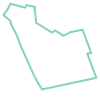

In [18]:
# here goes the exterior/outline of the poly's provided
zips["geometry"][1].exterior

---

#### What do the coords look like?

In [19]:
# this si what we are trying to parse out of the poly's
zips["geometry"][1].exterior.coords.xy

(array('d', [-73.71132911125308, -73.7106837407401, -73.70869392379949, -73.70713084684176, -73.70419967936363, -73.70218528698231, -73.70308721830736, -73.70098278625547, -73.71371033246908, -73.714741836008, -73.71567895968894, -73.71867075939582, -73.71966142935703, -73.72082889049311, -73.72117809110456, -73.72250622247415, -73.72270447144122, -73.72183610276068, -73.72109289651769, -73.71775341502477, -73.71730957335735, -73.71534601002345, -73.71553103019596, -73.71541781535772, -73.71509806179287, -73.71132911125308]),
 array('d', [40.74947450816085, 40.75004039450918, 40.74875836557177, 40.749582740537946, 40.750169552569766, 40.744741887753854, 40.744547257355144, 40.73889569923034, 40.736174704865455, 40.73782936804115, 40.73962914915626, 40.74631499057428, 40.748945236431474, 40.751173028173014, 40.75232189224561, 40.753358470814895, 40.75373371438336, 40.75486513130315, 40.7562813418113, 40.75534755942338, 40.75595782995615, 40.75550893330126, 40.75506458072391, 40.75499844

---

#### Parse x and y coordinates into separate columns

So we can see in the array above, that the coordinates for x and y are contained in a tuple. We need to separate these two out into individual columns for later visual analysis. 

In [20]:
def getPolyCoords(row, coord_type, geom="geometry"):
    """ Returns the coordinates ('x' or 'y') of edges of a 
    Polygon exterior.
    """
    
    #parse the exterior of the coordinates 
    exterior = row[geom].exterior
    
    # assign appropriate values
    if coord_type == "x":
        #get the x coords
        return list(exterior.coords.xy[0])
    if coord_type == "y":
        return list(exterior.coords.xy[1])
    
# assign to new cols
zips["poly_x"] = zips.apply(getPolyCoords,
                            coord_type="x",
                            axis=1
                           )
zips["poly_y"] = zips.apply(getPolyCoords,
                            coord_type="y",
                            axis=1
                           )
print(zips.shape)
zips.head()

(262, 14)


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,poly_x,poly_y
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...,"[-73.94922045816277, -73.95577163845807, -73.9...","[40.796909883482776, 40.787905470847036, 40.78..."
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756..."
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...,"[-73.97441674489379, -73.97449300390227, -73.9...","[40.736424418654764, 40.7361171300957, 40.7356..."
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...,"[-73.97986374196766, -73.98863956796875, -73.9...","[40.73497446573838, 40.72293224901508, 40.7241..."
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...,"[-74.04699098912498, -74.04723156029421, -74.0...","[40.69012472491997, 40.69040645829071, 40.6910..."


---
#### Add in Mercator Coordinates

Some mapping tiles, particularly the ones I'll be using in Bokeh, utilize mercator coordinates and therefore will display the data on a different scale than intended. I will keep both the lat/lon as well as the mercator coordinates. 

In [21]:
def conv_poly_ys(row):
    
    import math
    r = 6378137.0
    
    return [math.log(math.tan(math.pi/4+math.radians(x) / 2))*r for x in row]

def conv_poly_xs(row):
    
    import math
    r = 6378137.0
    
    return [math.radians(x)*r for x in row]

zips["xs"] = zips.poly_x.map(conv_poly_xs)
zips["ys"] = zips.poly_y.map(conv_poly_ys)

---

Now merge back to the main dataset.

In [22]:
#convert for this merge
df['postalCode'] = df["postalCode"].astype('str', copy=False)
# merge data
df = df.merge(
    zips[["postalCode", "poly_x", "poly_y", "xs", "ys"]],
    on="postalCode"
)
print(df.shape)
df.head()

(119607, 10)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422..."


####  What about Borough boundaries?
---

Now we have the coordinates at the zip code level. Later on it will be desired to possibly also have the coordinates at the Borough level. We'll also look at pulling in the neighborhood data, though it may be  a little more tricky. 

So let's pull those in as well

In [23]:
# get url
boro_url = "http://data.beta.nyc//dataset/68c0332f-c3bb-4a78-a0c1-32af515892d6/resource/7c164faa-4458-4ff2-9ef0-09db00b509ef/download/42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson"
#download the file from the url using  fun
download_data(boro_url)

os.listdir("./data/")

['f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson',
 '.DS_Store',
 'Rat_Sightings.pkl',
 'Rat_Sightings.csv',
 'd085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson',
 'neighborhoods.htm',
 '.ipynb_checkpoints',
 '42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson',
 'data']

In [24]:
os.chdir("./data/")
# assign filename to var
boro_data = r"42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson"
# read file into df
boro_data = gpd.read_file(boro_data)

# dims
print(boro_data.shape)

# view data
boro_data.head()

(104, 4)


,boroughCode,borough,@id,geometry
0,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.05050806403247 40.56642203416082...
1,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.05314036821109 40.57770271554575...
2,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.15945602438188 40.64144833332404...
3,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.08221272914938 40.64828016229008...
4,4,Queens,http://nyc.pediacities.com/Resource/Borough/Qu...,POLYGON ((-73.83668274106708 40.59494669701581...


In [25]:
# assign to new cols
boro_data["poly_x"] = boro_data.apply(getPolyCoords,
                            coord_type="x",
                            axis=1
                           )
boro_data["poly_y"] = boro_data.apply(getPolyCoords,
                            coord_type="y",
                            axis=1
                           )
print(boro_data.shape)
boro_data.head()

(104, 6)


,boroughCode,borough,@id,geometry,poly_x,poly_y
0,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.05050806403247 40.56642203416082...,"[-74.05050806403247, -74.04998352562575, -74.0...","[40.566422034160816, 40.56639592492827, 40.565..."
1,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.05314036821109 40.57770271554575...,"[-74.05314036821109, -74.05406044939875, -74.0...","[40.577702715545755, 40.57711644523887, 40.577..."
2,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.15945602438188 40.64144833332404...,"[-74.15945602438188, -74.15997875699617, -74.1...","[40.641448333324036, 40.64144648083637, 40.641..."
3,5,Staten Island,http://nyc.pediacities.com/Resource/Borough/St...,POLYGON ((-74.08221272914938 40.64828016229008...,"[-74.08221272914938, -74.08142228203805, -74.0...","[40.64828016229008, 40.64850472594939, 40.6482..."
4,4,Queens,http://nyc.pediacities.com/Resource/Borough/Qu...,POLYGON ((-73.83668274106708 40.59494669701581...,"[-73.83668274106708, -73.83670920760008, -73.8...","[40.59494669701581, 40.59471196329251, 40.5944..."


In [26]:
boro_data = (boro_data
        .groupby("borough")[["poly_x", "poly_y"]]
        .sum()
        .reset_index()
       )
boro_data.head()

,borough,poly_x,poly_y
0,Bronx,"[-73.89680883223775, -73.89693872998794, -73.8...","[40.79580844515979, 40.79563587285357, 40.7956..."
1,Brooklyn,"[-73.8670614947212, -73.86814728191004, -73.86...","[40.58208797679338, 40.58198890321927, 40.5816..."
2,Manhattan,"[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840..."
3,Queens,"[-73.83668274106708, -73.83670920760008, -73.8...","[40.59494669701581, 40.59471196329251, 40.5944..."
4,Staten Island,"[-74.05050806403247, -74.04998352562575, -74.0...","[40.566422034160816, 40.56639592492827, 40.565..."


In [27]:
boro_data["boro_xs"] = boro_data.poly_x.map(conv_poly_xs)
boro_data["boro_ys"] = boro_data.poly_y.map(conv_poly_ys)

df = df.merge(
    (boro_data[["borough", "poly_x", "poly_y",
                "boro_xs", "boro_ys"
               ]]
     .rename(columns={"borough":"Borough",
                      "poly_x":"boro_poly_x",
                      "poly_y":"boro_poly_y"
                     })
    ),
    on="Borough"
)
print(df.shape)
df.head()

(119607, 14)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,boro_poly_x,boro_poly_y,boro_xs,boro_ys
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."


---

#### Now ... neighborhoods?

Neighborhoods are rarely definite in their definitions even across different city departments let alone to natives and residents. This can make neighborhoods an absolute pain. Earlier, I took the time to incorporate a bunch of neighborhoods from a health.ny.gov webpage. However, the neighborhood boundary file has neighborhoods that the earlier table doesn't. 

To make matters more difficult, there isn't a mapping down to zipcodes because it is pretty frequent that neighborhoods in NYC have several if not many. So joining this to the dataset is not necessarily a joy. 

The only way, clean or not, is to spatially join the two datasets. The zip codes that I have, have to be spatially contained or within the neighborhoods defined in the geojson file. This of course means that I will be excluding the earlier set of neighborhoods but adding in the gemoetry coordinates will bear more fruit in the choropleth map. 

Spatial joins are a way to mmerge two geometry objects based on their spatial relationship with another. I'm going to use `geopandas`' `.sjoin()` method specifying the operation `op` of doing so equal to `'intersets'`. This is essentially equivalent to saying within or contains. This could become potentially messy, but let's give it a try. 

In [28]:
os.chdir("/Users/dominic/2scul4cul/rats_in_the_city/")

In [29]:
nhood_url = "http://data.beta.nyc//dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson"
download_data(nhood_url)
os.listdir("./data/")

['f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson',
 '.DS_Store',
 'Rat_Sightings.pkl',
 'Rat_Sightings.csv',
 'd085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson',
 'neighborhoods.htm',
 '.ipynb_checkpoints',
 '42c737fd496f4d6683bba25fb0e86e1dnycboroughboundaries.geojson',
 'data']

In [30]:
nhood_data = r"./data/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson"
nhood_data = gpd.read_file(nhood_data)

print(nhood_data.shape)
nhood_data.head()

(310, 5)


,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,POLYGON ((-73.84859700000018 40.87167000000012...
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333268196389 40.7388830992604,..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.169827 40.56107800000017, -74.16..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,POLYGON ((-74.15974815874296 40.64141652579018...
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,POLYGON ((-74.06077989345394 40.59318800468343...


In [31]:
# get unique zip codes and geometry
zips = zips[["postalCode", "geometry"]].reset_index(drop=True)
zips.head()

,postalCode,geometry
0,00083,POLYGON ((-73.94922045816277 40.79690988348278...
1,10001,POLYGON ((-74.00827017711134 40.75258714368449...
2,10002,POLYGON ((-73.97441674489379 40.73642441865476...
3,10003,POLYGON ((-73.97986374196766 40.73497446573838...
4,10004,POLYGON ((-74.04699098912498 40.69012472491997...


In [32]:
# subset nhood_data
nhood_data = nhood_data[["neighborhood", "borough", "geometry"]]

# now join
zips_nhoods = gpd.sjoin(zips,
                        nhood_data,
                        how="inner",
                        op="intersects"
                       )

# make a key - resolve duplicates
zips_nhoods = (zips_nhoods
               .drop_duplicates(subset=["neighborhood", "postalCode"])
               [["postalCode", "neighborhood"]]
               .reset_index(drop=True)
              )
print(zips_nhoods.shape)
zips_nhoods.head()

(973, 2)


,postalCode,neighborhood
0,00083,Midtown
1,10001,Midtown
2,10010,Midtown
3,10016,Midtown
4,10017,Midtown


---

This looks like quite a bit. Technically, there shouldn't be much more than 262 which is the number of unique zip codes. 

In [33]:
zips_nhoods.postalCode.nunique()

247

----

**Success ... !?**

What this means is that zip codes are possibly being shared across neighborhoods as well as vice versa. This might be a close of a resolution that can be reached barring lengthy discussions with NYC government. 

For our local resolution, we are going to limit the neighborhoods to each unique zip code. Meaning there will be a forced 1 to many relationship to deal with the many to many. 

In [34]:
# resolve the many to many
zips_nhoods = (zips_nhoods
               .drop_duplicates(subset=["postalCode"])
               .reset_index(drop=True)
              )
zips_nhoods.head()

,postalCode,neighborhood
0,00083,Midtown
1,10001,Midtown
2,10010,Midtown
3,10016,Midtown
4,10017,Midtown


---

So, now we can perform the same processing steps on the neighborhood data to get it incorporated and we have a zipcode to neighborhood mapping that will allow us to populate to the main dataframe.

In [35]:
nhood_data.head()

,neighborhood,borough,geometry
index_right,,,
0,Allerton,Bronx,POLYGON ((-73.84859700000018 40.87167000000012...
1,Alley Pond Park,Queens,"POLYGON ((-73.74333268196389 40.7388830992604,..."
2,Arden Heights,Staten Island,"POLYGON ((-74.169827 40.56107800000017, -74.16..."
3,Arlington,Staten Island,POLYGON ((-74.15974815874296 40.64141652579018...
4,Arrochar,Staten Island,POLYGON ((-74.06077989345394 40.59318800468343...


In [36]:
# assign to new cols
nhood_data["poly_x"] = nhood_data.apply(getPolyCoords,
                            coord_type="x",
                            axis=1
                           )
nhood_data["poly_y"] = nhood_data.apply(getPolyCoords,
                            coord_type="y",
                            axis=1
                           )
print(nhood_data.shape)
nhood_data.head()

(310, 5)


,neighborhood,borough,geometry,poly_x,poly_y
index_right,,,,,
0,Allerton,Bronx,POLYGON ((-73.84859700000018 40.87167000000012...,"[-73.84859700000018, -73.84582253683678, -73.8...","[40.871670000000115, 40.870239076236174, 40.85..."
1,Alley Pond Park,Queens,"POLYGON ((-73.74333268196389 40.7388830992604,...","[-73.74333268196389, -73.74371398888943, -73.7...","[40.7388830992604, 40.73940324889485, 40.74077..."
2,Arden Heights,Staten Island,"POLYGON ((-74.169827 40.56107800000017, -74.16...","[-74.169827, -74.16982257259502, -74.16707, -7...","[40.561078000000165, 40.56105732753589, 40.548..."
3,Arlington,Staten Island,POLYGON ((-74.15974815874296 40.64141652579018...,"[-74.15974815874296, -74.15997875699631, -74.1...","[40.64141652579018, 40.64144648083636, 40.6415..."
4,Arrochar,Staten Island,POLYGON ((-74.06077989345394 40.59318800468343...,"[-74.06077989345394, -74.06079176448593, -74.0...","[40.59318800468343, 40.593177948540486, 40.592..."


In [37]:
nhood_data["nhood_xs"] = nhood_data.poly_x.map(conv_poly_xs)
nhood_data["nhood_ys"] = nhood_data.poly_y.map(conv_poly_ys)

nhood_data = (nhood_data[["neighborhood", "poly_x",
                          "poly_y", "nhood_xs",
                          "nhood_ys"
                         ]]
              .merge(zips_nhoods)
             )

nhood_data.head()

,neighborhood,poly_x,poly_y,nhood_xs,nhood_ys,postalCode
0,Arverne,"[-73.78953462130708, -73.78954114938684, -73.7...","[40.5999718149268, 40.59994369480516, 40.59991...","[-8214213.419916536, -8214214.146619049, -8214...","[4953515.454477953, 4953511.331688628, 4953506...",11692
1,Arverne,"[-73.78953462130708, -73.78954114938684, -73.7...","[40.5999718149268, 40.59994369480516, 40.59991...","[-8214213.419916536, -8214214.146619049, -8214...","[4953515.454477953, 4953511.331688628, 4953506...",11693
2,Astoria,"[-73.90160305064738, -73.9026963813229, -73.90...","[40.76777029715587, 40.76688928653443, 40.7657...","[-8226688.820404699, -8226810.5294187665, -822...","[4978147.945391637, 4978018.452573618, 4977855...",11102
3,Astoria,"[-73.90160305064738, -73.9026963813229, -73.90...","[40.76777029715587, 40.76688928653443, 40.7657...","[-8226688.820404699, -8226810.5294187665, -822...","[4978147.945391637, 4978018.452573618, 4977855...",11105
4,Battery Park City,"[-74.01375400000018, -74.01426200000019, -74.0...","[40.71369, 40.710928000000195, 40.704733000000...","[-8239173.406978634, -8239229.957279959, -8239...","[4970202.286918407, 4969796.6579270745, 496888...",10282


---

Merge back to main dataframe.

In [38]:
print(df.shape)
df.head()

(119607, 14)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,boro_poly_x,boro_poly_y,boro_xs,boro_ys
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856..."


In [39]:
# remove the old neighborhoods
df = df.drop("Neighborhood", axis=1)

# merge
df = df.merge(
    (nhood_data
     .rename(columns={"neighborhood":"Neighborhood",
                      "poly_x":"nhood_poly_x",
                      "poly_y":"nhood_poly_y"
                     })
    ),
    on="postalCode"
)
print(df.shape)
df.head()

(119943, 18)


,Created Date,Location Type,postalCode,Location,Borough,poly_x,poly_y,xs,ys,boro_poly_x,boro_poly_y,boro_xs,boro_ys,Neighborhood,nhood_poly_x,nhood_poly_y,nhood_xs,nhood_ys
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947..."
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947..."
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947..."
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947..."
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...","[40.68449147254294, 40.68388774915497, 40.6840...","[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947..."


---
Add in Seasons & Parse out Years

In [40]:
# define seasons
winter = ["01", "02", "03"]
spring = ["04", "05", "06"]
summer = ["07", "08", "09"]
fall = ["10", "11", "12"]

def season(row):
    
    month = row.split("/")[0]

    if month in winter:
        return "winter"
    elif month in spring:
        return "spring"
    elif month in summer:
        return "summer"
    elif month in fall:
        return 'fall'
    else:
        return "NA"

seasons = df["Created Date"].map(season)
pd.Series(seasons).head()

0    summer
1    summer
2    winter
3    summer
4    spring
Name: Created Date, dtype: object

---

Now years

In [41]:
def year(row):
    
    return row.split("/")[2].split(' ')[0]

years = df["Created Date"].map(year)
pd.Series(years).head()

0    2017
1    2016
2    2016
3    2017
4    2017
Name: Created Date, dtype: object

---

Now months

In [42]:
def get_month(row):
    
    return row.split("/")[0]

months = df["Created Date"].map(get_month)
pd.Series(months).head()

0    08
1    09
2    01
3    07
4    06
Name: Created Date, dtype: object

---

Conv. months to month names

In [43]:
# create mapping for months
d_months = {"01":"Jan", "02":"Feb", "03":"Mar",
          "04":"Apr", "05":"May", "06":"June",
          "07":"July", "08":"Aug", "09":"Sep",
          "10":"Oct", "11":"Nov", "12":"Dec"}

months = months.map(d_months)
pd.Series(months).head()

0     Aug
1     Sep
2     Jan
3    July
4    June
Name: Created Date, dtype: object

---

Now we can add these columns to the dataset.

In [44]:
df["Year"], df["Season"], df["Month"]= years, seasons, months
df.head()

,Created Date,Location Type,postalCode,Location,Borough,poly_x,poly_y,xs,ys,boro_poly_x,...,boro_xs,boro_ys,Neighborhood,nhood_poly_x,nhood_poly_y,nhood_xs,nhood_ys,Year,Season,Month
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,summer,Aug
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2016,summer,Sep
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2016,winter,Jan
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,summer,July
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,spring,June


Success!

---
Now we have our wrangled dataset and can move on to visualization.

In [45]:
df.to_pickle("./data/Rat_Sightings.pkl")
df.head()

,Created Date,Location Type,postalCode,Location,Borough,poly_x,poly_y,xs,ys,boro_poly_x,...,boro_xs,boro_ys,Neighborhood,nhood_poly_x,nhood_poly_y,nhood_xs,nhood_ys,Year,Season,Month
0,08/02/2017 12:00:00 AM,3+ Family Mixed Use Building,10001,"(40.7456163166638, -73.98757087477563)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,summer,Aug
1,09/08/2016 12:00:00 AM,Commercial Building,10001,"(40.74864397036016, -73.98954087053794)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2016,summer,Sep
2,01/12/2016 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925101726878, -74.00199584240312)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2016,winter,Jan
3,07/14/2017 12:00:00 AM,Construction Site,10001,"(40.745421892217756, -73.9929157080262)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,summer,July
4,06/15/2017 12:00:00 AM,Vacant Lot,10001,"(40.74518584464681, -73.99293016871866)",Manhattan,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.180545851, 4976422...","[-74.01092841268033, -74.01193259911061, -74.0...",...,"[-8238858.864036998, -8238970.649559078, -8238...","[4965915.024392721, 4965826.398628179, 4965856...",Midtown,"[-73.9622312516561, -73.96791907791587, -73.97...","[40.75452213042196, 40.747960560355295, 40.752...","[-8233437.920868702, -8234071.086791659, -8235...","[4976200.882773609, 4975236.682617902, 4975947...",2017,spring,June
